************************************************************
************************* sub001_2 *************************
************************************************************
Loaded 94406 samples
Loaded 6 events
Extracted ranges for 6 events
************************************************************
************************* sub002_2 *************************
************************************************************
Loaded 95307 samples
Loaded 6 events
Extracted ranges for 6 events


/Users/jtm/.pyenv/versions/3.7.7/envs/pyplr/lib/python3.7/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


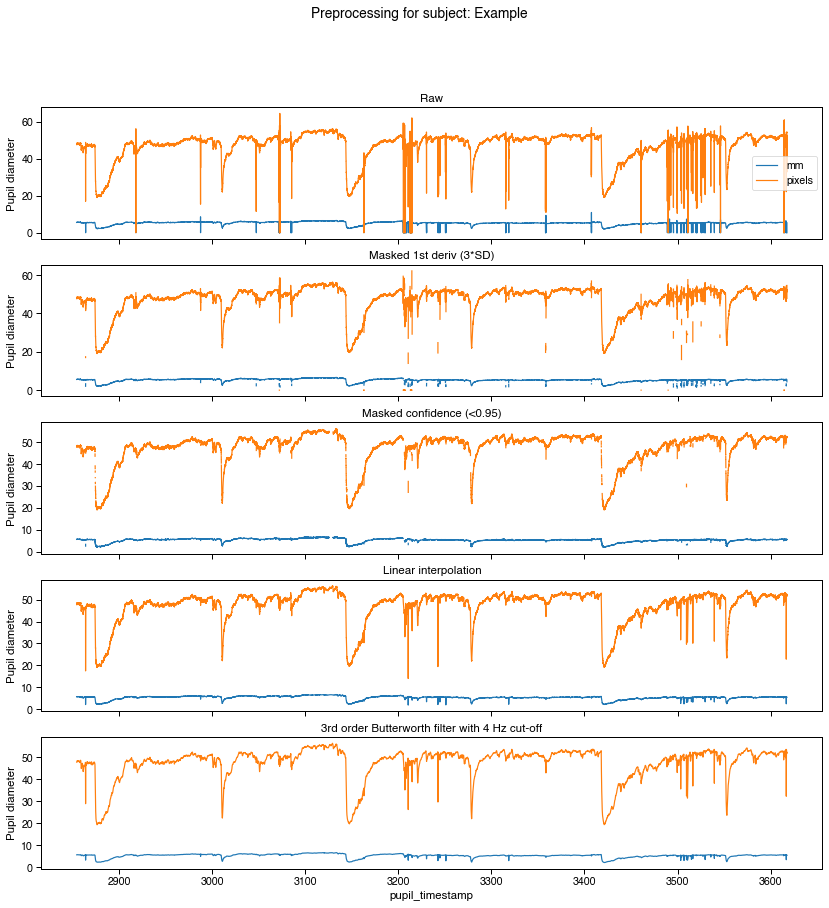

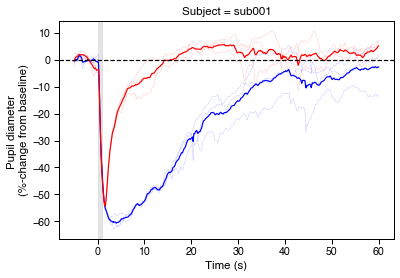

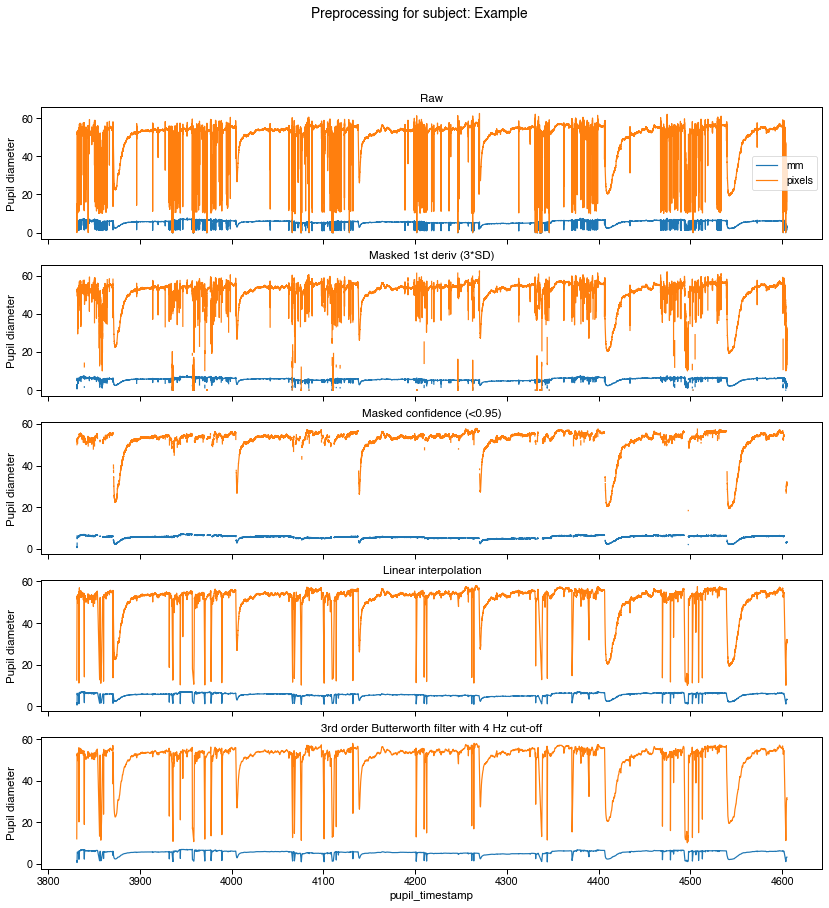

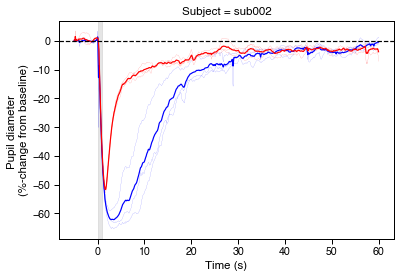

In [117]:
import os.path as op

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper', font_scale=1.2)

from pyplr import graphing, utils, preproc
from pyplr.plr import PLR

# Some useful constants
SAMPLE_RATE = 120
DURATION = 7800
ONSET_IDX = 600
    
# Columns to load
use_cols = ['confidence',
            'method',
            'pupil_timestamp',
            'eye_id',
            'diameter_3d',
            'diameter']

# Pupil Labs recording directory
subjects = {'001': [r'/Users/jtm/OneDrive - Nexus365/data/PIPR/sub001_2', '000'],
            '002': [r'/Users/jtm/OneDrive - Nexus365/data/PIPR/sub002_2', '001']}

for k in subjects.keys():
    # Get a handle on a subject        
    rec = subjects[k][0]
    export = subjects[k][1]        
    s = utils.new_subject(
        rec, export=export, out_dir_nm='pyplr_analysis')

    # Load pupil data
    samples = utils.load_pupil(
        s['data_dir'], eye_id='best', method='3d', cols=use_cols)
    
    # Pupil columns to analyse
    pupil_cols = ['diameter_3d', 'diameter']

    # Make figure for processing
    f, axs = graphing.pupil_preprocessing(nrows=5, subject='Example')

    # Plot the raw data
    samples[pupil_cols].plot(title='Raw', ax=axs[0], legend=True)
    axs[0].legend(loc='center right', labels=['mm', 'pixels'])

    # Mask first derivative
    samples = preproc.mask_pupil_first_derivative(
        samples, threshold=4.0, mask_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Masked 1st deriv (3*SD)', ax=axs[1], legend=False)

    # Mask confidence
    samples = preproc.mask_pupil_confidence(
        samples, threshold=0.99, mask_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Masked confidence (<0.95)', ax=axs[2], legend=False)

    # Interpolate
    samples = preproc.interpolate_pupil(
        samples, interp_cols=pupil_cols)
    samples[pupil_cols].plot(
        title='Linear interpolation', ax=axs[3], legend=False)

    # Smooth  
    samples = preproc.butterworth_series(
        samples, fields=pupil_cols, filt_order=3, 
        cutoff_freq=4/(SAMPLE_RATE/2))
    samples[pupil_cols].plot(
        title='3rd order Butterworth filter with 4 Hz cut-off', 
        ax=axs[4], legend=False)
    
    # Load events
    events = utils.load_annotations(s['data_dir'])

    # Extract the event ranges
    ranges = utils.extract(
        samples, 
        events, 
        offset=-ONSET_IDX, 
        duration=DURATION, 
        borrow_attributes=['color'])
    
    # Calculate baselines
    baselines = ranges.loc[:, range(0, ONSET_IDX), :].mean(level=0)

    # New columns for percent signal change
    ranges = preproc.percent_signal_change(
        ranges, baselines, pupil_cols)
    if k=='002':
        ranges.loc[(3),'diameter_pc'].iloc[0:25]=0
        
    # Convert samples index-level to time (s)
    new_onset = (ranges.index.get_level_values('onset').unique() - ONSET_IDX) / SAMPLE_RATE
    ranges.index = ranges.index.set_levels(levels=new_onset, level='onset')
    ranges.to_csv(op.join(s['out_dir'], 'ranges.csv'))
    
    # Plot PIPRs
    fig, ax = plt.subplots(figsize=(6,4))
    for r in range(6):
        c = ranges.loc[r, 'color'][0]
        ranges.loc[r, 'diameter_pc'].plot(color=c, lw='.1', ax=ax, legend=False)
        
    # Now show the means
    avgs = (ranges.reset_index()
                  .groupby(['color','onset'], as_index=False)
                  .mean())
    sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='color', 
                 palette={'blue':'b','red':'r'}, legend=False)
    
    # Aesthetics
    ax.axvspan(0, 1, color='k', alpha=.1)
    ax.axhline(0, 0, 1, color='k', ls='--')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pupil diameter \n(%-change from baseline)')
    ax.set_title('Subject = {}'.format(s['id'][:-2]))
    
    # save
    fig.savefig('../img/PIPR_{}.svg'.format(s['id']))
    
    #average_plr = ranges.mean(level=1)['diameter_3d'].to_numpy()
    #plr = PLR(average_plr, 
    #          sample_rate=SAMPLE_RATE, 
    #          onset_idx=ONSET_IDX, 
    #          stim_duration=1)
    #plr.plot()

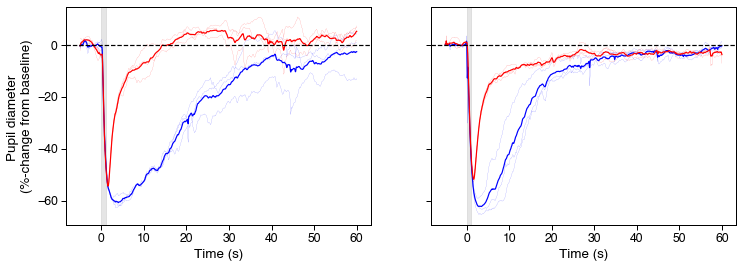

In [112]:
sns.set_context('paper', font_scale=1.4)
fig, axs = plt.subplots(1,2, sharey=True, figsize=(12,4))
for i, k in enumerate(subjects.keys()):
    ranges = pd.read_csv(op.join(subjects[k][0],'pyplr_analysis','ranges.csv'), index_col=['event','onset'])
    for r in range(6):
        c = ranges.loc[r, 'color'][0]
        ranges.loc[r, 'diameter_pc'].plot(color=c, lw='.1', ax=axs[i], legend=False)
        
    # Now show the means
    avgs = (ranges.reset_index()
                  .groupby(['color','onset'], as_index=False)
                  .mean())
    sns.lineplot(data=avgs, x='onset', y='diameter_pc', hue='color', 
                 palette={'blue':'b','red':'r'}, legend=False, ax=axs[i])
    
    # Aesthetics
    axs[i].axvspan(0, 1, color='k', alpha=.1)
    axs[i].axhline(0, 0, 1, color='k', ls='--')
    axs[i].set_xlabel('Time (s)')
    axs[i].set_ylabel('Pupil diameter \n(%-change from baseline)')
fig.savefig('../img/PIPRs.tiff', dpi=300)


In [99]:
ax

,event,onset,eye_id,confidence,diameter,method,diameter_3d,interpolated,orig_idx,color,diameter_3d_pc,diameter_pc
0,0,-5.000000,0,1.0,47.436091,pye3d 0.0.6 real-time,5.524240,0,2869.094845,blue,0.433693,0.508316
1,0,-4.991667,0,1.0,47.424486,pye3d 0.0.6 real-time,5.522785,0,2869.102458,blue,0.407232,0.483726
2,0,-4.983333,0,1.0,47.411586,pye3d 0.0.6 real-time,5.521200,0,2869.109848,blue,0.378420,0.456394
3,0,-4.975000,0,1.0,47.397772,pye3d 0.0.6 real-time,5.519531,0,2869.117894,blue,0.348081,0.427124
4,0,-4.966667,0,1.0,47.383448,pye3d 0.0.6 real-time,5.517827,0,2869.126284,blue,0.317092,0.396775
...,...,...,...,...,...,...,...,...,...,...,...,...
46795,5,59.958333,0,1.0,52.261000,pye3d 0.0.6 real-time,5.565027,0,3609.518111,red,2.955846,1.694375
46796,5,59.966667,0,1.0,52.265910,pye3d 0.0.6 real-time,5.565131,0,3609.526132,red,2.957770,1.703930
46797,5,59.975000,0,1.0,52.271053,pye3d 0.0.6 real-time,5.565248,0,3609.534109,red,2.959933,1.713938
46798,5,59.983333,0,1.0,52.276324,pye3d 0.0.6 real-time,5.565376,0,3609.542381,red,2.962294,1.724194


In [119]:
examples = ranges.loc[:, ['diameter_3d','confidence']].copy(deep=True)
examples['stimulus'] = 0
examples.loc[(slice(None), slice(0.0,0.999)), 'stimulus'] = 1
examples = examples.reset_index().rename(
    columns={'event':'PLR_event','onset':'time', 'diameter_3d':'raw_pupil_mm_c>.95_interpolated_smoothed'})
examples.to_csv('~/example_PLRs_2.csv')
examples

,PLR_event,time,raw_pupil_mm_c>.95_interpolated_smoothed,confidence,stimulus
0,0,-5.000000,6.172990,1.0,0
1,0,-4.991667,6.171640,1.0,0
2,0,-4.983333,6.170196,1.0,0
3,0,-4.975000,6.168684,1.0,0
4,0,-4.966667,6.167125,1.0,0
...,...,...,...,...,...
46795,5,59.958333,7.019064,1.0,0
46796,5,59.966667,7.019223,1.0,0
46797,5,59.975000,7.019386,1.0,0
46798,5,59.983333,7.019541,1.0,0


In [110]:
new = examples.copy(deep=True)

In [120]:
new['raw_pupil_mm_c>.95_interpolated_smoothed'] = examples['raw_pupil_mm_c>.95_interpolated_smoothed']
new

,PLR_event,time,raw_pupil_mm,confidence,stimulus,raw_pupil_mm_c>.95,raw_pupil_mm_c>.95_interpolated,raw_pupil_mm_c>.95_interpolated_smoothed
0,0,-5.000000,6.178436,1.0,0,6.178436,6.178436,6.172990
1,0,-4.991667,6.185660,1.0,0,6.185660,6.185660,6.171640
2,0,-4.983333,6.172338,1.0,0,6.172338,6.172338,6.170196
3,0,-4.975000,6.172509,1.0,0,6.172509,6.172509,6.168684
4,0,-4.966667,6.164519,1.0,0,6.164519,6.164519,6.167125
...,...,...,...,...,...,...,...,...
46795,5,59.958333,7.009149,1.0,0,7.009149,7.009149,7.019064
46796,5,59.966667,7.017560,1.0,0,7.017560,7.017560,7.019223
46797,5,59.975000,7.017611,1.0,0,7.017611,7.017611,7.019386
46798,5,59.983333,7.005743,1.0,0,7.005743,7.005743,7.019541


In [121]:
new.to_csv('~/PLR_examples_2.csv', index=False)

In [126]:
ranges.color.to_clipboard()

In [144]:
from pyplr.plr import PLR

plr = PLR(ranges.loc[(0,slice(-2,5)), 'diameter_3d'].to_numpy(), sample_rate=120, onset_idx=600, stim_duration=1)

<AxesSubplot:xlabel='onset'>

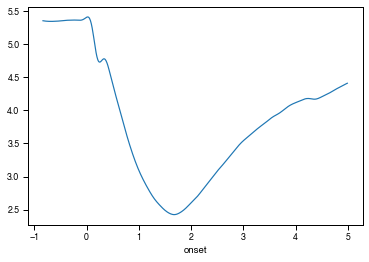

In [155]:
ranges[ranges.color=='red'].mean(level=1).diameter_3d.iloc[500:1200].plot()

In [7]:
ranges

eye_id  confidence   diameter                 method  \
event onset                                                              
0     -5.000000        0    0.984709  55.097706  pye3d 0.0.6 real-time   
      -4.991667        0    0.954249  55.113263  pye3d 0.0.6 real-time   
      -4.983333        0    0.853838  55.131685  pye3d 0.0.6 real-time   
      -4.975000        0    0.931521  55.152616  pye3d 0.0.6 real-time   
      -4.966667        0    0.923264  55.175582  pye3d 0.0.6 real-time   
...                  ...         ...        ...                    ...   
5      59.958333       0    0.963825  56.836947  pye3d 0.0.6 real-time   
       59.966667       0    1.000000  56.794325  pye3d 0.0.6 real-time   
       59.975000       0    0.966632  56.744285  pye3d 0.0.6 real-time   
       59.983333       0    0.938282  56.687532  pye3d 0.0.6 real-time   
       59.991667       0    0.942704  56.625070  pye3d 0.0.6 real-time   

                  diameter_3d  interpolated     orig_idx color  \
event onset                                                      
0     -5.000000      6.203546             0  3865.537090  blue   
      -4.991667      6.205158             0  3865.542821  blue   
      -4.983333      6.207078             1  3865.550708  blue   
      -4.975000      6.209265             1  3865.559840  blue   
      -4.966667      6.211668             1  3865.565276  blue   
...                       ...           ...          ...   ...   
5      59.958333     5.099078             0  4597.303931  blue   
       59.966667     5.094947             0  4597.312108  blue   
       59.975000     5.090192             0  4597.319886  blue   
       59.983333     5.084889             1  4597.328365  blue   
       59.991667     5.079140             1  4597.335948  blue   

                  diameter_3d_pc  diameter_pc  
event onset                                    
0     -5.000000        -0.074960    -0.075024  
      -4.991667        -0.049003    -0.046811  
      -4.983333        -0.018078    -0.013400  
      -4.975000         0.017161     0.024559  
      -4.966667         0.055866     0.066211  
...                          ...          ...  
5      59.958333       -1.000238     0.240360  
       59.966667       -1.080444     0.165190  
       59.975000       -1.172760     0.076936  
       59.983333       -1.275719    -0.023156  
       59.991667       -1.387352    -0.133317  

[46800 rows x 10 columns]